In [4]:
import arcgis
from arcgis.gis import GIS
from arcgis.features import GeoAccessor, GeoSeriesAccessor
import pandas as pd
import numpy as np
import geopandas as gpd
import warnings
import matplotlib.pyplot as plt
from arcgis.raster.functions import ImageryLayer
import rasterio
from shapely.geometry import Point
from arcgis.raster.functions import *
from ipywidgets import *
from IPython.display import display
warnings.simplefilter(action='ignore', category=FutureWarning)

In [288]:
gis = GIS("https://ucsdonline.maps.arcgis.com/home", client_id="k3CTgUsBimpl63GM")

Please sign in to your GIS and paste the code that is obtained below.
If a web browser does not automatically open, please navigate to the URL below yourself instead.
Opening web browser to navigate to: https://ucsdonline.maps.arcgis.com/sharing/rest/oauth2/authorize?response_type=code&client_id=k3CTgUsBimpl63GM&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&state=VCBcizSRFinHLJVsNpopv7ENRj3eXf&allow_verification=false


Enter code obtained on signing in using SAML:  ········


In [111]:
p_gdf = gpd.read_file("precipitation_data.geojson")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


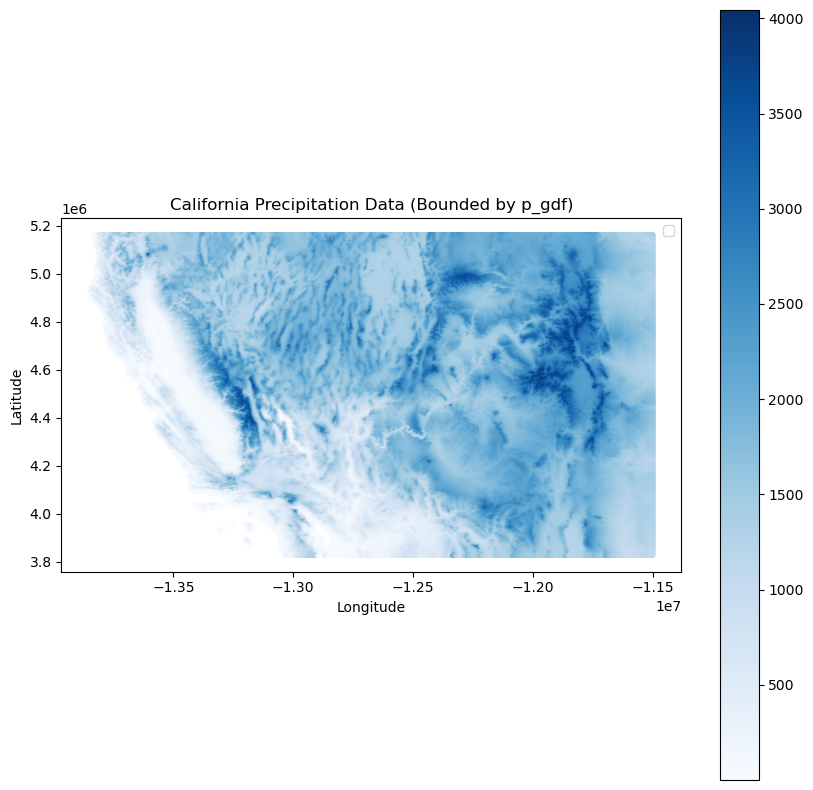

In [213]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Compute the bounding box of p_gdf
minx, miny, maxx, maxy = p_gdf.total_bounds


# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the bounded precipitation data
gdf.plot(ax=ax, column='temp', cmap='Blues', markersize=5, legend=True)

# # Plot p_gdf data on top
# p_gdf.plot(ax=ax, color='red', markersize=5, label="p_gdf Points")

# Add Titles, Labels, and a Legend
plt.title("California Precipitation Data (Bounded by p_gdf)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()

plt.show()


In [210]:
gdf = gdf.to_crs(3587)

<Projected CRS: ESRI:102008>
Name: North_America_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

,longitude,latitude,elevation,geometry
0,-1.383143e+07,5.164438e+06,4.127424,POINT (-13831431.052 5164437.829)
1,-1.382845e+07,5.164438e+06,142.311295,POINT (-13828447.378 5164437.829)
2,-1.382546e+07,5.164438e+06,236.407364,POINT (-13825463.704 5164437.829)
3,-1.382248e+07,5.164438e+06,117.354477,POINT (-13822480.03 5164437.829)
4,-1.381950e+07,5.164438e+06,154.851013,POINT (-13819496.356 5164437.829)
...,...,...,...,...
311731,-1.151013e+07,3.824768e+06,1112.638184,POINT (-11510132.536 3824768.12)
311732,-1.150715e+07,3.824768e+06,1102.182129,POINT (-11507148.862 3824768.12)
311733,-1.150417e+07,3.824768e+06,1091.462402,POINT (-11504165.188 3824768.12)
311734,-1.150118e+07,3.824768e+06,1101.080078,POINT (-11501181.513 3824768.12)


In [289]:
usa_elevation = ImageryLayer('https://elevation.arcgis.com/arcgis/rest/services/WorldElevation/Terrain/ImageServer',gis)
usa_mean_temperature = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Mean_Temperature/ImageServer", gis)
usa_landcover_gap = ImageryLayer("https://landscape3.arcgis.com/arcgis/rest/services/USA_Landcover_GAP/ImageServer", gis)

In [290]:

xmin, ymin, xmax, ymax = gdf.total_bounds

study_area_extent_dict ={"xmin": -13872247.8308, "ymin": 3823276.2826, "xmax": -12701573.1963, "ymax": 5165929.6661}
study_area_extent_dict["spatialReference"] =usa_elevation.properties.spatialReference


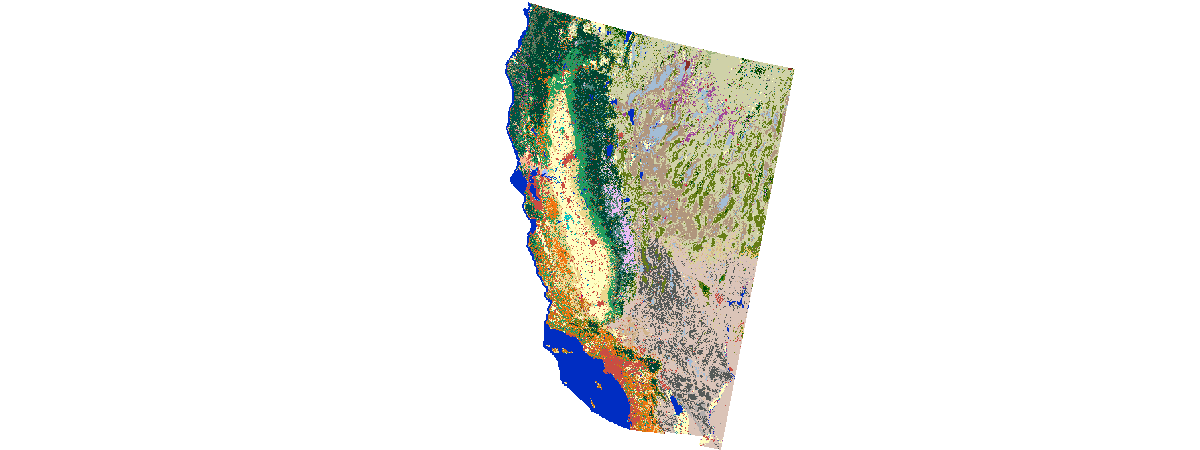

In [291]:
usa_landcover_gap.extent = study_area_extent_dict

soil_clip = clip(raster=usa_landcover_gap, geometry=study_area_extent_dict)
soil_clip


In [ ]:
soil_clip

In [294]:
lulc_n = remap(raster=soil_clip,
                  input_ranges=[0.0,289.5, 289.6,459.5, 459.6,499.5, 499.6,507.5, 507.6,513.5,
                               513.6,554.5, 554.6,557.5, 557.6,563.5, 564.5,576.5, 576.6,600.0],
                  output_values=[1,5,3,0,0,1,0,9,8,0])

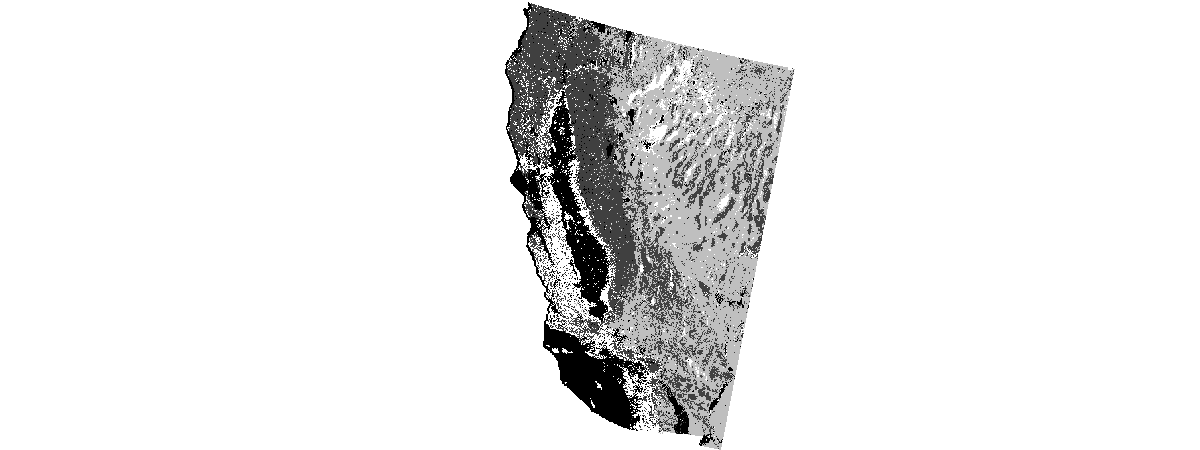

In [295]:
lulc_n

In [302]:
exported_image = lulc_n.export_image(
    export_format='tiff'
)

In [303]:
exported_image

{'href': 'https://landscape3.arcgis.com/arcgis/rest/directories/arcgisoutput/USA_Landcover_GAP_ImageServer/x_____xUYb3ijc0SRch7H-8olgUyg..x_____x_ags_e6701f1b_21af_40ac_b371_81f4051640db.tif',
 'width': 1200,
 'height': 450,
 'extent': {'xmin': -3702440.918396347,
  'ymin': -729793.5851244805,
  'xmax': -226385.16623167787,
  'ymax': 573727.3219372705,
  'spatialReference': {'wkid': 102008, 'latestWkid': 102008}},
 'scale': 0}

In [304]:
with rasterio.open("landcover.tif") as src:
    band1 = src.read(1)  # Assuming single-band raster (precipitation values)
    rows, cols = np.where(band1 > 0)  # Filter for valid pixels
    xs, ys = rasterio.transform.xy(src.transform, rows, cols)
    values = band1[rows, cols]

# Create DataFrame
df = pd.DataFrame({"longitude": xs, "latitude": ys, "cover": values})

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=src.crs)



In [306]:
gdf

,longitude,latitude,cover,geometry
0,-2.165735e+06,563588.825993,5,POINT (-2165734.605 563588.826)
1,-2.162838e+06,563588.825993,1,POINT (-2162837.892 563588.826)
2,-2.162838e+06,560692.112867,1,POINT (-2162837.892 560692.113)
3,-2.159941e+06,560692.112867,1,POINT (-2159941.178 560692.113)
4,-2.157044e+06,560692.112867,1,POINT (-2157044.465 560692.113)
...,...,...,...,...
75533,-1.621153e+06,-725448.515434,1,POINT (-1621152.537 -725448.515)
75534,-1.618256e+06,-725448.515434,3,POINT (-1618255.824 -725448.515)
75535,-1.615359e+06,-725448.515434,3,POINT (-1615359.111 -725448.515)
75536,-1.618256e+06,-728345.228561,3,POINT (-1618255.824 -728345.229)


In [307]:
gdf = gdf.to_crs(3857)

In [308]:
gdf.to_file("landcover.geojson", driver="GeoJSON")

In [118]:
p_gdf.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [342]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from scipy.spatial import cKDTree

geojson_files = ["elevation.geojson","landcover.geojson", "precipitation.geojson", 'temp.geojson']

gdfs = [gpd.read_file(file) for file in geojson_files]
gdfs = [gdf.to_crs("EPSG:4326") for gdf in gdfs]

def spatial_merge(base_gdf, new_gdf, max_distance=0.1):
    """Merge two GeoDataFrames based on nearest neighbor."""
    base_coords = list(zip(base_gdf.geometry.x, base_gdf.geometry.y))
    new_coords = list(zip(new_gdf.geometry.x, new_gdf.geometry.y))
    
    tree = cKDTree(new_coords)
    distances, indices = tree.query(base_coords, k=1) 
    
    match_mask = distances <= max_distance
    
    matched_data = new_gdf.iloc[indices[match_mask]].reset_index(drop=True)
    merged_gdf = base_gdf.loc[match_mask].reset_index(drop=True)
    
    new_columns = [col for col in matched_data.columns 
                  if col != "geometry" and col not in merged_gdf.columns]
    
    for col in new_columns:
        merged_gdf[col] = matched_data[col].values
    
    return merged_gdf

merged_gdf = gdfs[0]
for i, gdf in enumerate(gdfs[1:], 1):
    print(f"Merging with {geojson_files[i]}...")
    merged_gdf = spatial_merge(merged_gdf, gdf)

# Save the merged GeoDataFrame to a new GeoJSON
# merged_gdf.to_file("merged_output.geojson", driver="GeoJSON")
# print("Merged GeoJSON saved successfully.")

Merging with landcover.geojson...
Merging with precipitation.geojson...
Merging with temp.geojson...


In [343]:
merged_gdf = merged_gdf.drop(columns=["longitude", "latitude"])

In [316]:
merged_gdf['cover'].value_counts()

cover
1    38139
3    21026
5    20242
8      386
9      375
Name: count, dtype: int64

In [317]:
merged_gdf

,elevation,geometry,cover,precipitation,temp
0,4.127424,POINT (-124.24986 42.02308),5,5.073659,11.660081
1,142.311290,POINT (-124.22306 42.02308),5,5.073659,11.672755
2,236.407360,POINT (-124.19625 42.02308),1,5.377477,12.073840
3,117.354480,POINT (-124.16945 42.02308),1,5.377477,11.759786
4,154.851010,POINT (-124.14265 42.02308),1,5.618339,12.471117
...,...,...,...,...,...
80163,84.579575,POINT (-114.52044 32.46699),3,0.084487,22.851097
80164,94.992706,POINT (-114.49364 32.46699),3,0.084487,22.841679
80165,95.574287,POINT (-114.46684 32.46699),3,0.084487,22.841679
80166,100.960920,POINT (-114.44003 32.46699),3,0.084487,22.832994


In [344]:
import geopandas as gpd

# Step 1: Prepare data with proper CRS
transmission_lines = gpd.read_file("Transmission_Line.geojson").to_crs(epsg=3857)
merged_gdf = merged_gdf.to_crs(epsg=3857)

# Step 2: Create spatial index SEPARATELY from original data
lines_sindex = transmission_lines.sindex  # Keep both GDF and index!

# Optimized distance calculation using unary union
def calculate_distances(points_gdf, lines_gdf):
    """Vectorized distance calculation using combined line geometry"""
    return points_gdf.geometry.distance(lines_gdf.unary_union)

# Get distances (fast)
merged_gdf['distance_to_line'] = calculate_distances(merged_gdf, transmission_lines)

# # Optional: Find nearest line using spatial index
# def get_nearest_line(point):
#     """Find closest line using spatial index lookup"""
#     possible_matches = list(lines_sindex.nearest(point.bounds, return_all=False))
#     if possible_matches:
#         return transmission_lines.iloc[possible_matches[0]].geometry
#     return None

# merged_gdf['nearest_line'] = merged_gdf.geometry.apply(get_nearest_line)

# Save results
merged_gdf.to_file("merged_with_distances.geojson", driver="GeoJSON")


/tmp/ipykernel_612/343431690.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  return points_gdf.geometry.distance(lines_gdf.unary_union)


In [5]:
gdf = gpd.read_file("merged_with_distances.geojson")

In [6]:
gdf['cover'].unique()

array([5, 1, 8, 3, 9], dtype=int32)

In [7]:
wildfires = gpd.read_file("California_Fire_Perimeters_(all).geojson")

In [11]:
wildfires_gdf = wildfires[['OBJECTID','geometry']]

,elevation,cover,precipitation,temp,distance_to_line,geometry,index_right,OBJECTID
0,4.127424,5,5.073659,11.660081,18707.129735,POINT (-13831431.052 5164437.829),NaN,NaN
1,142.311290,5,5.073659,11.672755,16936.883866,POINT (-13828447.378 5164437.829),NaN,NaN
2,236.407360,1,5.377477,12.073840,15542.328995,POINT (-13825463.704 5164437.829),NaN,NaN
3,117.354480,1,5.377477,11.759786,14631.287345,POINT (-13822480.03 5164437.829),NaN,NaN
4,154.851010,1,5.618339,12.471117,14296.495075,POINT (-13819496.356 5164437.829),NaN,NaN
...,...,...,...,...,...,...,...,...
80163,84.579575,3,0.084487,22.851097,29226.600343,POINT (-12748357.323 3824768.12),NaN,NaN
80164,94.992706,3,0.084487,22.841679,28792.248268,POINT (-12745373.649 3824768.12),NaN,NaN
80165,95.574287,3,0.084487,22.841679,28663.523447,POINT (-12742389.975 3824768.12),NaN,NaN
80166,100.960920,3,0.084487,22.832994,28844.517949,POINT (-12739406.301 3824768.12),NaN,NaN


In [8]:
wildfires_gdf = wildfires_gdf.to_crs(gdf.crs)

joined_gdf = gpd.sjoin(gdf, wildfires_gdf, how="inner", predicate="within")

wildfire_counts = joined_gdf.index.value_counts()

gdf["wildfire_count"] = 0  

gdf.loc[wildfire_counts.index, "wildfire_count"] = wildfire_counts.values

print(gdf.head())


NameError: name 'wildfires_gdf' is not defined

In [29]:
gdf['wildfire_count'].value_counts()

wildfire_count
0     60556
1     12256
2      4777
3      1715
4       559
5       174
6        89
7        22
8        12
9         5
10        2
11        1
Name: count, dtype: int64

In [31]:
gdf.to_file("fire_data.geojson", driver="GeoJSON")

In [34]:
gdf

,elevation,cover,precipitation,temp,distance_to_line,geometry,wildfire_count
0,4.127424,5,5.073659,11.660081,18707.129735,POINT (-13831431.052 5164437.829),0
1,142.311290,5,5.073659,11.672755,16936.883866,POINT (-13828447.378 5164437.829),0
2,236.407360,1,5.377477,12.073840,15542.328995,POINT (-13825463.704 5164437.829),0
3,117.354480,1,5.377477,11.759786,14631.287345,POINT (-13822480.03 5164437.829),0
4,154.851010,1,5.618339,12.471117,14296.495075,POINT (-13819496.356 5164437.829),0
...,...,...,...,...,...,...,...
80163,84.579575,3,0.084487,22.851097,29226.600343,POINT (-12748357.323 3824768.12),0
80164,94.992706,3,0.084487,22.841679,28792.248268,POINT (-12745373.649 3824768.12),0
80165,95.574287,3,0.084487,22.841679,28663.523447,POINT (-12742389.975 3824768.12),0
80166,100.960920,3,0.084487,22.832994,28844.517949,POINT (-12739406.301 3824768.12),0


In [36]:
import pandas as pd
import statsmodels.api as sm

# Load dataset (replace with actual file path if needed)
df = gpd.read_file("fire_data.geojson")

# Define features (X) and target variable (y)
X = df[['elevation', 'cover', 'precipitation', 'temp', 'distance_to_line']]
X = sm.add_constant(X)  # Add intercept term
y = df['wildfire_count']  # Target: wildfire occurrences

# Fit Poisson regression model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()

# Predict fire risk scores
df['fire_risk_score'] = poisson_model.predict(X)

# Print summary and results
print(poisson_model.summary())
print(df[['geometry', 'fire_risk_score']].head())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         wildfire_count   No. Observations:                80168
Model:                            GLM   Df Residuals:                    80162
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -67761.
Date:                Wed, 12 Mar 2025   Deviance:                       90474.
Time:                        17:23:27   Pearson chi2:                 1.36e+05
No. Iterations:                     6   Pseudo R-squ. (CS):            0.06335
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2079      0.053  

In [45]:

df['elevation'] = df['elevation'] * 3.28084  


df['cover'] = df['cover'].map({
    1: 'Forest and Woodland',
    2: 'Shrub and Herb Vegetation',
    3: 'Semi-Desert',
    4: 'Polar & High Montane Vegetation',
    5: 'Aquatic Vegetation',
    6: 'Nonvascular & Sparse Vascular Rock Vegetation',
    7: 'Agricultural Vegetation',
    8: 'Introduced & Semi Natural Vegetation',
    9: 'Recently Disturbed or Modified'
}).fillna('Other')

df['temp'] = (df['temp'] * 9/5) + 32 

df.to_file("risk_fire_data.geojson", driver="GeoJSON")

In [50]:
df.to_file("risk_fire_data.geojson", driver="GeoJSON")

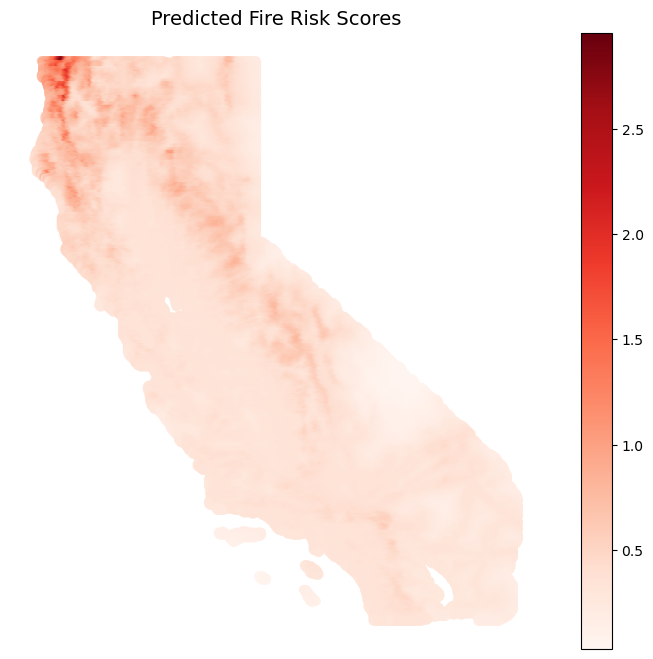

In [42]:
fig, ax = plt.subplots(figsize=(10, 8))
df.plot(column='fire_risk_score', cmap='Reds', legend=True, alpha=0.75, ax=ax)

# Customize the plot
ax.set_title("Predicted Fire Risk Scores", fontsize=14)
ax.set_axis_off()  
plt.show()

In [9]:
gdf = gpd.read_file("risk_fire_data.geojson")

In [10]:
gdf['cover'].unique()

array(['Aquatic Vegetation', 'Forest and Woodland',
       'Introduced & Semi Natural Vegetation', 'Semi-Desert',
       'Recently Disturbed or Modified'], dtype=object)

In [53]:
df = df.to_crs(4326)